## iris데이터 회귀분석

In [1]:
import pandas as pd

file_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

iris = pd.read_csv(file_name, names=["sepal_length","sepal_width","petal_length", "petal_width","species"])

독립변수는 petal_length 컬럼, 종속변수는 petal_width 컬럼으로 해보자.

* (1) DataFrame 생성

* (2) 데이터와 회귀선 그래프

* (3) Spark를 사용하여 회귀분석하고 계수 출력

* (4) 실제와 예측 출력

* (4) 정확성 평가

(1) DataFrame 생성

In [2]:
import pyspark
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [3]:
irisDf =spark.createDataFrame(iris)

In [4]:
irisDf.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



In [21]:
irisDf.show(10)

+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|    species|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
|         5.4|        3.9|         1.7|        0.4|Iris-setosa|
|         4.6|        3.4|         1.4|        0.3|Iris-setosa|
|         5.0|        3.4|         1.5|        0.2|Iris-setosa|
|         4.4|        2.9|         1.4|        0.2|Iris-setosa|
|         4.9|        3.1|         1.5|        0.1|Iris-setosa|
+------------+-----------+------------+-----------+-----------+
only showing top 10 rows



(2) 데이터간 상관관계 heatmap을 출력

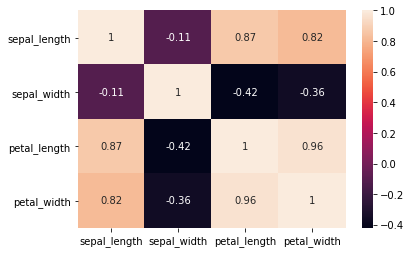

In [6]:
import seaborn as sns
%matplotlib inline
corr = iris.corr()
sns.heatmap(corr, annot=True)
#plt.show()

(3) Spark를 사용하여 회귀분석하고 계수 출력

In [12]:
(trainDf, testDf) = irisDf.randomSplit([0.65, 0.35])

In [13]:
print(trainDf.count())
print(testDf.count())

99
51


In [54]:
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler(inputCols = ["petal_width"], outputCol = 'features')

In [55]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='petal_length', maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [56]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[va, lr])
model = pipeline.fit(trainDf)

In [57]:
modelTrainDf = model.transform(trainDf)

In [58]:
print("Coefficients: {}".format(model.stages[-1].coefficients))
print("Intercept: {:.3f}".format(model.stages[-1].intercept))

Coefficients: [1.8642820867349732]
Intercept: 1.554


In [59]:
modelTestDf=model.transform(testDf)

(4) 실제와 예측 출력

In [60]:
modelTestDf.select('petal_length','prediction').show(10)

+------------+------------------+
|petal_length|        prediction|
+------------+------------------+
|         1.4|1.9264681347760673|
|         1.3|1.9264681347760673|
|         1.4|2.1128963434495645|
|         1.0|1.9264681347760673|
|         1.4|2.1128963434495645|
|         4.5| 4.722891264878527|
|         1.5|  1.74003992610257|
|         1.5|1.9264681347760673|
|         1.3|2.1128963434495645|
|         1.4|1.9264681347760673|
+------------+------------------+
only showing top 10 rows



(4) 정확성 평가

In [61]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="petal_length", predictionCol="prediction", metricName="rmse")

#metric name RMSE

In [62]:
rmse=evaluator.evaluate(modelTestDf)
f"Root Mean Squared Error (RMSE) on test data: {rmse:.3f}"

'Root Mean Squared Error (RMSE) on test data: 0.529'

In [63]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="petal_length", predictionCol="prediction", metricName="r2")
f"r2: {evaluator.evaluate(modelTestDf):.3f}"

'r2: 0.914'